In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.optimizers import AdamW
from tensorflow.keras.layers import BatchNormalization

# Loading and splitting the dataset

In [54]:
(train_set_raw, valid_set_raw, test_set_raw), (data_info)  = tfds.load(
    name="oxford_flowers102",
    split=["test", "validation", "train"],
    as_supervised=True,
    shuffle_files = True,
    with_info = True
)

In [55]:
n_classes = data_info.features["label"].num_classes

In [56]:
train_set_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [57]:
valid_set_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [58]:
print(train_set_raw.cardinality().numpy())

6149


In [59]:
print(valid_set_raw.cardinality().numpy())

1020


In [60]:
print(test_set_raw.cardinality().numpy())

1020


# Exploring the dataset

In [61]:
data_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see this
    [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102

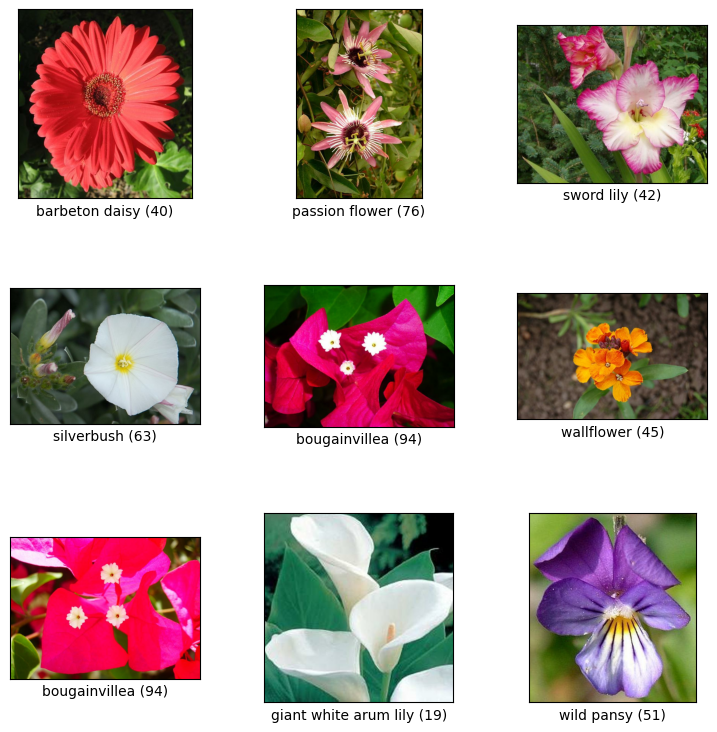

In [62]:
fig = tfds.show_examples(train_set_raw, tfds.builder('oxford_flowers102').info)

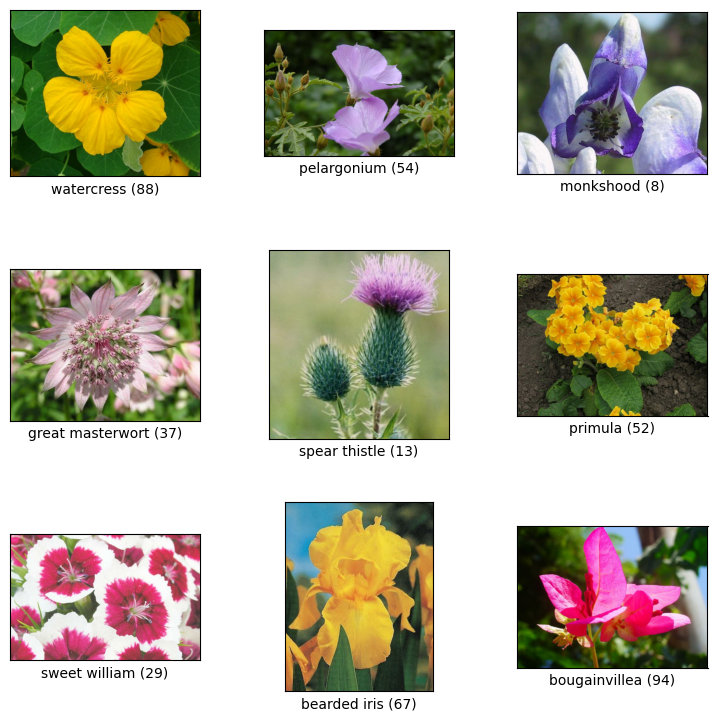

In [63]:
fig2 = tfds.show_examples(valid_set_raw, tfds.builder('oxford_flowers102').info)

# Data preparation

In [64]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

# Building the model

In [65]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)


In [66]:
for layer in base_model.layers:
    layer.trainable = False

In [67]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])


# Training and evaluating it

In [68]:
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
193/193 [==============================] - 37s 160ms/step - loss: 1.7287 - accuracy: 0.6047 - val_loss: 1.7218 - val_accuracy: 0.6363
Epoch 2/3
193/193 [==============================] - 31s 152ms/step - loss: 0.5458 - accuracy: 0.8639 - val_loss: 0.7301 - val_accuracy: 0.8069
Epoch 3/3
193/193 [==============================] - 33s 156ms/step - loss: 0.2683 - accuracy: 0.9239 - val_loss: 0.6234 - val_accuracy: 0.8275


In [69]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=5,
                                                     restore_best_weights=True)

history = model.fit(train_set, validation_data=valid_set, epochs=50, callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/50
193/193 [==============================] - 70s 312ms/step - loss: 0.2969 - accuracy: 0.9236 - val_loss: 0.3246 - val_accuracy: 0.9157
Epoch 2/50
193/193 [==============================] - 59s 296ms/step - loss: 0.0208 - accuracy: 0.9971 - val_loss: 0.2304 - val_accuracy: 0.9412
Epoch 3/50
193/193 [==============================] - 60s 300ms/step - loss: 0.0091 - accuracy: 0.9989 - val_loss: 0.2140 - val_accuracy: 0.9392
Epoch 4/50
193/193 [==============================] - 60s 296ms/step - loss: 0.0041 - accuracy: 0.9997 - val_loss: 0.2073 - val_accuracy: 0.9451
Epoch 5/50
193/193 [==============================] - 60s 301ms/step - loss: 0.0041 - accuracy: 0.9995 - val_loss: 0.2070 - val_accuracy: 0.9471
Epoch 6/50
193/193 [==============================] - 61s 303ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.2022 - val_accuracy: 0.9480
Epoch 7/50
193/193 [==============================] - 61s 297ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.2002 - val_ac

In [70]:
score = model.evaluate(test_set)


32/32 [==============================] - 4s 120ms/step - loss: 0.2019 - accuracy: 0.9510


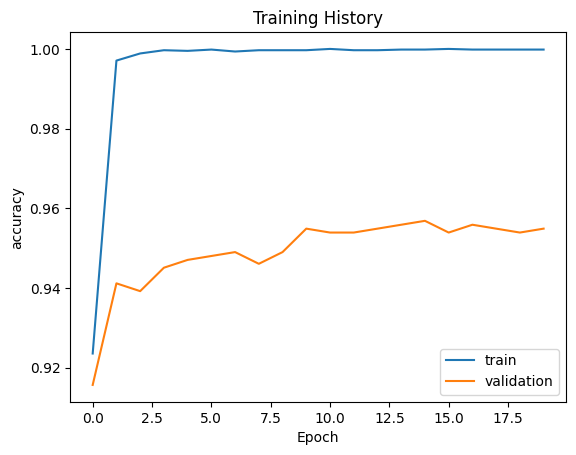

In [71]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title('Training History'),
plt.xlabel('Epoch'),
plt.ylabel('accuracy')
plt.show()

# Saving the model

In [72]:
model.save('my_model.keras')

In [ ]:
# new_model = tf.keras.models.load_model('my_model.keras')